## Import Libraries

In [81]:
import pandas as pd
import numpy as np
import math
from statistics import mean, median, mode
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
from numpy import array, hstack
import joblib

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense, Bidirectional, TimeDistributed, Reshape, Flatten, Attention


from tensorflow.keras.layers import  Input, Concatenate
from tensorflow.keras.models import Model, load_model


In [6]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = (9,16)
mpl.rcParams['axes.grid'] = False

### Import and Inspect Datasets

In [7]:
rainfall_data = pd.read_csv("../data/rainfall history_data.csv")
rainfall_data.isnull().sum()

Name                      0
Date time                 0
Maximum Temperature       0
Minimum Temperature       0
Temperature               0
Wind Chill              457
Heat Index             2184
Precipitation             0
Snow                      0
Snow Depth                0
Wind Speed                0
Wind Direction            0
Wind Gust               770
Visibility                0
Cloud Cover               0
Relative Humidity         0
Conditions                0
dtype: int64

In [8]:
river_level = pd.read_csv("../data/blackadder-water-river level.csv")
river_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2049 non-null   object 
 1   min_level  2049 non-null   float64
 2   avg_level  2049 non-null   float64
 3   max_level  2049 non-null   float64
dtypes: float64(3), object(1)
memory usage: 64.2+ KB


In [9]:
river_flow_rate = pd.read_csv("../data/blackadder-water guage daily flow.csv", header=20, names = ['date', 'flowrate'])
river_flow_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      17500 non-null  object 
 1   flowrate  17500 non-null  float64
dtypes: float64(1), object(1)
memory usage: 273.6+ KB


### Data Cleaning and preprocesing

###### Rainfall Data

In [10]:
rainfall_data

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,"55.715559, -2.403535",01/01/2017,42.2,36.6,38.6,27.9,NaN,0.24,0.0,0.0,18.3,219.58,30.0,27.2,53.8,79.63,"Rain, Partially cloudy"
1,"55.715559, -2.403535",01/02/2017,39.3,32.1,35.7,24.9,NaN,0.02,0.0,0.0,16.1,283.75,30.0,29.7,45.8,80.26,"Rain, Partially cloudy"
2,"55.715559, -2.403535",01/03/2017,46.5,36.8,43.0,30.0,NaN,0.00,0.0,0.0,24.1,259.17,33.9,31.1,75.9,84.68,Overcast
3,"55.715559, -2.403535",01/04/2017,45.8,36.6,39.8,31.7,NaN,0.00,0.0,0.0,13.8,327.08,27.7,29.9,75.6,65.51,Overcast
4,"55.715559, -2.403535",01/05/2017,36.6,29.9,33.2,23.9,NaN,0.00,0.0,0.0,8.0,247.13,NaN,30.5,75.6,80.44,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,"55.715559, -2.403535",12/27/2022,37.7,29.0,33.9,22.9,NaN,0.18,0.0,0.0,12.7,211.29,16.1,18.2,67.6,95.56,"Rain, Partially cloudy"
2187,"55.715559, -2.403535",12/28/2022,47.6,39.0,42.4,32.0,NaN,0.15,0.0,0.0,24.1,188.79,34.4,16.3,95.8,93.03,"Rain, Overcast"
2188,"55.715559, -2.403535",12/29/2022,44.0,35.9,40.8,27.1,NaN,0.02,0.0,0.0,21.9,237.92,34.4,33.7,63.8,83.83,"Rain, Partially cloudy"
2189,"55.715559, -2.403535",12/30/2022,45.8,34.5,42.4,30.2,NaN,0.30,0.0,0.0,28.8,201.25,42.5,22.9,87.5,89.04,"Rain, Overcast"


In [11]:
rainfall_data.isnull().sum()

Name                      0
Date time                 0
Maximum Temperature       0
Minimum Temperature       0
Temperature               0
Wind Chill              457
Heat Index             2184
Precipitation             0
Snow                      0
Snow Depth                0
Wind Speed                0
Wind Direction            0
Wind Gust               770
Visibility                0
Cloud Cover               0
Relative Humidity         0
Conditions                0
dtype: int64

In [12]:
len(rainfall_data)

2191

In [13]:
# ratio of missing Wind Chill data points
457/2191

0.20858055682336832

We will explore the possibility of replacing missing values, or completely dropping this column

In [14]:
# ratio of missing Wind Gust data points
770/2170

0.3548387096774194

This ratio is quite high, so we will drop this column later

In [15]:
rainfall_data.describe()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
count,2191.000000,2191.000000,2191.000000,1734.000000,7.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,1421.000000,2191.000000,2191.000000,2191.000000
mean,54.380466,42.001689,48.121041,34.008189,82.928571,0.076298,0.025285,0.111661,16.613647,198.962305,31.578958,23.193063,67.987723,83.640242
std,10.185398,8.203651,8.683741,7.805776,1.632702,0.162494,0.333728,0.787883,6.472699,62.502861,9.594130,8.164970,17.553251,8.122850
min,26.700000,15.000000,23.300000,7.600000,80.700000,0.000000,0.000000,0.000000,3.400000,14.580000,0.000000,0.800000,0.000000,54.810000
25%,46.700000,35.700000,41.200000,28.000000,82.100000,0.000000,0.000000,0.000000,11.400000,166.190000,27.700000,18.200000,56.800000,78.370000
50%,53.900000,42.000000,48.000000,34.100000,82.600000,0.010000,0.000000,0.000000,16.100000,218.330000,32.200000,24.900000,69.600000,84.220000
75%,62.000000,48.500000,55.300000,40.400000,83.900000,0.080000,0.000000,0.000000,20.800000,240.020000,36.900000,28.700000,80.900000,89.390000
max,85.400000,61.800000,72.300000,49.700000,85.200000,1.510000,13.390000,13.390000,49.300000,331.250000,74.900000,45.200000,100.000000,99.930000


The 75th percentile of data in the Snow and Snow Depth columns are 0, so we will drop these columns

#### Rainfall Data feature engineering

####### Replace or drop Wind Chill data points?

We check for the centrality of the Wind Chill data

In [16]:
rainfall_data['Wind Chill'].mean()

34.008189158016144

In [17]:
rainfall_data['Wind Chill'].median()

34.1

In [18]:
rainfall_data['Wind Chill'].mode()

0    37.2
Name: Wind Chill, dtype: float64

Since the Wind Chill data is very statistically centered, we will replace the missing values with the median 

In [19]:
data_no_na = rainfall_data.copy()
data_no_na['Wind Chill'] = data_no_na['Wind Chill'].fillna(data_no_na['Wind Chill'].median())

In [20]:
data_no_na.isnull().sum()

Name                      0
Date time                 0
Maximum Temperature       0
Minimum Temperature       0
Temperature               0
Wind Chill                0
Heat Index             2184
Precipitation             0
Snow                      0
Snow Depth                0
Wind Speed                0
Wind Direction            0
Wind Gust               770
Visibility                0
Cloud Cover               0
Relative Humidity         0
Conditions                0
dtype: int64

In [21]:
# Now we drop the Heat Index, Wind Gust, Snow and Snow Depth columns
data_no_na = data_no_na.drop(['Heat Index', 'Wind Gust', 'Snow', 'Snow Depth'], axis=1)

In [22]:
data_no_na.isnull().sum()

Name                   0
Date time              0
Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Wind Chill             0
Precipitation          0
Wind Speed             0
Wind Direction         0
Visibility             0
Cloud Cover            0
Relative Humidity      0
Conditions             0
dtype: int64

In [23]:
data_no_na.describe()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,54.380466,42.001689,48.121041,34.027339,0.076298,16.613647,198.962305,23.193063,67.987723,83.640242
std,10.185398,8.203651,8.683741,6.943838,0.162494,6.472699,62.502861,8.164970,17.553251,8.122850
min,26.700000,15.000000,23.300000,7.600000,0.000000,3.400000,14.580000,0.800000,0.000000,54.810000
25%,46.700000,35.700000,41.200000,29.650000,0.000000,11.400000,166.190000,18.200000,56.800000,78.370000
50%,53.900000,42.000000,48.000000,34.100000,0.010000,16.100000,218.330000,24.900000,69.600000,84.220000
75%,62.000000,48.500000,55.300000,38.500000,0.080000,20.800000,240.020000,28.700000,80.900000,89.390000
max,85.400000,61.800000,72.300000,49.700000,1.510000,49.300000,331.250000,45.200000,100.000000,99.930000


Now we have sucessfully removed null data and invalid columns 


In [24]:
data_no_na

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions
0,"55.715559, -2.403535",01/01/2017,42.2,36.6,38.6,27.9,0.24,18.3,219.58,27.2,53.8,79.63,"Rain, Partially cloudy"
1,"55.715559, -2.403535",01/02/2017,39.3,32.1,35.7,24.9,0.02,16.1,283.75,29.7,45.8,80.26,"Rain, Partially cloudy"
2,"55.715559, -2.403535",01/03/2017,46.5,36.8,43.0,30.0,0.00,24.1,259.17,31.1,75.9,84.68,Overcast
3,"55.715559, -2.403535",01/04/2017,45.8,36.6,39.8,31.7,0.00,13.8,327.08,29.9,75.6,65.51,Overcast
4,"55.715559, -2.403535",01/05/2017,36.6,29.9,33.2,23.9,0.00,8.0,247.13,30.5,75.6,80.44,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,"55.715559, -2.403535",12/27/2022,37.7,29.0,33.9,22.9,0.18,12.7,211.29,18.2,67.6,95.56,"Rain, Partially cloudy"
2187,"55.715559, -2.403535",12/28/2022,47.6,39.0,42.4,32.0,0.15,24.1,188.79,16.3,95.8,93.03,"Rain, Overcast"
2188,"55.715559, -2.403535",12/29/2022,44.0,35.9,40.8,27.1,0.02,21.9,237.92,33.7,63.8,83.83,"Rain, Partially cloudy"
2189,"55.715559, -2.403535",12/30/2022,45.8,34.5,42.4,30.2,0.30,28.8,201.25,22.9,87.5,89.04,"Rain, Overcast"


###### Categorical Columns

In [25]:
data_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 2191 non-null   object 
 1   Date time            2191 non-null   object 
 2   Maximum Temperature  2191 non-null   float64
 3   Minimum Temperature  2191 non-null   float64
 4   Temperature          2191 non-null   float64
 5   Wind Chill           2191 non-null   float64
 6   Precipitation        2191 non-null   float64
 7   Wind Speed           2191 non-null   float64
 8   Wind Direction       2191 non-null   float64
 9   Visibility           2191 non-null   float64
 10  Cloud Cover          2191 non-null   float64
 11  Relative Humidity    2191 non-null   float64
 12  Conditions           2191 non-null   object 
dtypes: float64(10), object(3)
memory usage: 222.6+ KB


In [26]:
data_no_na.Name.unique()

array(['55.715559, -2.403535'], dtype=object)

In [27]:
data_no_na.Conditions.unique()

array(['Rain, Partially cloudy', 'Overcast', 'Rain, Overcast',
       'Partially cloudy', 'Snow, Partially cloudy', 'Clear',
       'Snow, Overcast', 'Rain'], dtype=object)

In [28]:
data_no_na.Conditions.value_counts()

Conditions
Rain, Partially cloudy    666
Partially cloudy          607
Rain, Overcast            540
Overcast                  275
Snow, Partially cloudy     49
Clear                      36
Snow, Overcast             14
Rain                        4
Name: count, dtype: int64

since the Name column has only one value all through, we will drop it. And we will codify the Conditions column using One-Hot encoder since the conditions are nominal in nature

In [29]:
# drop Name column
data_no_na = data_no_na.drop('Name', axis=1)

In [31]:
# Encode Conditions Column

# initialize encoder
encoder = OneHotEncoder()

# Encode the Conditions column
encoded_conditions = encoder.fit_transform(data_no_na[['Conditions']]).toarray()

# Create a new dataframe with the encoded data
new_conditions_df = pd.DataFrame(encoded_conditions, columns = encoder.get_feature_names_out(['Conditions']))

# concatenate the new conditions columns to the complete dataset
data_encoded = pd.concat([data_no_na, new_conditions_df], axis=1)

# drop original conditions column
data_encoded = data_encoded.drop('Conditions', axis=1)

In [32]:
data_encoded

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy","Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy"
0,01/01/2017,42.2,36.6,38.6,27.9,0.24,18.3,219.58,27.2,53.8,79.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,01/02/2017,39.3,32.1,35.7,24.9,0.02,16.1,283.75,29.7,45.8,80.26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,01/03/2017,46.5,36.8,43.0,30.0,0.00,24.1,259.17,31.1,75.9,84.68,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/04/2017,45.8,36.6,39.8,31.7,0.00,13.8,327.08,29.9,75.6,65.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/05/2017,36.6,29.9,33.2,23.9,0.00,8.0,247.13,30.5,75.6,80.44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,12/27/2022,37.7,29.0,33.9,22.9,0.18,12.7,211.29,18.2,67.6,95.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2187,12/28/2022,47.6,39.0,42.4,32.0,0.15,24.1,188.79,16.3,95.8,93.03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2188,12/29/2022,44.0,35.9,40.8,27.1,0.02,21.9,237.92,33.7,63.8,83.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2189,12/30/2022,45.8,34.5,42.4,30.2,0.30,28.8,201.25,22.9,87.5,89.04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### River Level Data

In [33]:
river_level

,date,min_level,avg_level,max_level
0,2017-03-31,0.434,0.440,0.446
1,2017-04-01,0.422,0.447,0.498
2,2017-04-02,0.438,0.469,0.504
3,2017-04-03,0.411,0.422,0.437
4,2017-04-04,0.389,0.400,0.411
...,...,...,...,...
2044,2023-05-03,0.300,0.300,0.300
2045,2023-05-04,0.300,0.300,0.300
2046,2023-05-05,0.300,0.300,0.300
2047,2023-05-06,0.300,0.314,0.380


In [34]:
river_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2049 non-null   object 
 1   min_level  2049 non-null   float64
 2   avg_level  2049 non-null   float64
 3   max_level  2049 non-null   float64
dtypes: float64(3), object(1)
memory usage: 64.2+ KB


In [35]:
river_level.describe()

,min_level,avg_level,max_level
count,2049.000000,2049.000000,2049.000000
mean,0.367757,0.391895,0.422303
std,0.135537,0.170325,0.222392
min,0.000000,0.035000,0.212000
25%,0.279000,0.285000,0.291000
50%,0.323000,0.331000,0.341000
75%,0.420000,0.441000,0.466000
max,1.484000,1.963000,2.142000


It can be observed that the max values are significantly higher than the 75th percentile values, but we will not alter this since the project is focused on detecting these outlier situations (i.e. flooding)

In [36]:
river_level.isnull().sum()

date         0
min_level    0
avg_level    0
max_level    0
dtype: int64

The river level data is clean

### River Flow data

In [37]:
river_flow_rate

,date,flowrate
0,1973-11-02,0.364
1,1973-11-03,0.356
2,1973-11-04,0.391
3,1973-11-05,0.441
4,1973-11-06,0.404
...,...,...
17495,2021-09-26,0.274
17496,2021-09-27,0.376
17497,2021-09-28,0.413
17498,2021-09-29,0.409


In [38]:
river_flow_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      17500 non-null  object 
 1   flowrate  17500 non-null  float64
dtypes: float64(1), object(1)
memory usage: 273.6+ KB


In [39]:
river_flow_rate.describe()

,flowrate
count,17500.000000
mean,1.839641
std,3.057542
min,0.116000
25%,0.522000
50%,1.020000
75%,1.996000
max,78.570000


In [40]:
river_flow_rate.isnull().sum()

date        0
flowrate    0
dtype: int64

The river flow rate data is clean

## Combine Rainfall, River Level and River Flow Rate data using Date column

In [41]:
# Reformat rainfall data date column
data_encoded.head()

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy","Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy"
0,01/01/2017,42.2,36.6,38.6,27.9,0.24,18.3,219.58,27.2,53.8,79.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,01/02/2017,39.3,32.1,35.7,24.9,0.02,16.1,283.75,29.7,45.8,80.26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,01/03/2017,46.5,36.8,43.0,30.0,0.00,24.1,259.17,31.1,75.9,84.68,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/04/2017,45.8,36.6,39.8,31.7,0.00,13.8,327.08,29.9,75.6,65.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/05/2017,36.6,29.9,33.2,23.9,0.00,8.0,247.13,30.5,75.6,80.44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# rename the 'Date Time' column to 'date'
data_encoded = data_encoded.rename(columns={'Date time':'date'})

In [43]:
# reformat the date strings to match the other datasets
data_encoded['date'] = pd.to_datetime(data_encoded['date'], format='%m/%d/%Y')
data_encoded['date'] = data_encoded['date'].dt.strftime('%Y-%m-%d')

In [44]:
data_encoded

,date,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy","Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy"
0,2017-01-01,42.2,36.6,38.6,27.9,0.24,18.3,219.58,27.2,53.8,79.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2017-01-02,39.3,32.1,35.7,24.9,0.02,16.1,283.75,29.7,45.8,80.26,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2017-01-03,46.5,36.8,43.0,30.0,0.00,24.1,259.17,31.1,75.9,84.68,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-04,45.8,36.6,39.8,31.7,0.00,13.8,327.08,29.9,75.6,65.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-05,36.6,29.9,33.2,23.9,0.00,8.0,247.13,30.5,75.6,80.44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2022-12-27,37.7,29.0,33.9,22.9,0.18,12.7,211.29,18.2,67.6,95.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2187,2022-12-28,47.6,39.0,42.4,32.0,0.15,24.1,188.79,16.3,95.8,93.03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2188,2022-12-29,44.0,35.9,40.8,27.1,0.02,21.9,237.92,33.7,63.8,83.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2189,2022-12-30,45.8,34.5,42.4,30.2,0.30,28.8,201.25,22.9,87.5,89.04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Merge the datasets on the date column

In [45]:
flow_n_level = pd.merge(river_level, river_flow_rate, on='date')
combined_data = pd.merge(data_encoded, flow_n_level, on='date')

In [46]:
combined_data = combined_data[:1343]

In [47]:
combined_data

,date,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Precipitation,Wind Speed,Wind Direction,Visibility,Cloud Cover,...,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy","Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",min_level,avg_level,max_level,flowrate
0,2017-03-31,54.8,49.2,51.6,45.2,0.04,28.8,196.21,20.8,71.3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.434,0.440,0.446,1.782
1,2017-04-01,54.8,45.8,48.9,40.8,0.25,18.3,244.75,18.6,74.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.422,0.447,0.498,2.162
2,2017-04-02,55.7,41.1,47.8,36.7,0.00,13.9,244.67,29.8,57.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.438,0.469,0.504,1.869
3,2017-04-03,54.6,37.5,45.8,32.2,0.00,23.0,223.83,29.9,60.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.411,0.422,0.437,1.539
4,2017-04-04,53.0,44.0,48.6,38.0,0.00,19.4,257.92,26.6,55.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.389,0.400,0.411,1.344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,2020-12-19,53.0,41.1,46.1,33.7,0.02,24.1,189.21,32.2,53.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.585,0.598,0.613,3.275
1339,2020-12-20,46.5,39.3,42.6,31.5,0.08,21.9,214.58,22.7,56.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.562,0.591,0.612,2.845
1340,2020-12-21,44.0,38.4,40.9,32.8,0.04,21.9,210.04,18.3,78.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.532,0.546,0.562,2.425
1341,2020-12-22,42.2,33.2,37.6,29.8,0.00,12.7,231.88,36.9,48.9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.501,0.516,0.532,2.106


Since min_level and avg_level will naturally correlate with max_level, we should drop them to avoid multicollinearity

In [48]:
merged_data = combined_data.drop(['min_level', 'avg_level'], axis=1)

In [49]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               1343 non-null   object 
 1   Maximum Temperature                1343 non-null   float64
 2   Minimum Temperature                1343 non-null   float64
 3   Temperature                        1343 non-null   float64
 4   Wind Chill                         1343 non-null   float64
 5   Precipitation                      1343 non-null   float64
 6   Wind Speed                         1343 non-null   float64
 7   Wind Direction                     1343 non-null   float64
 8   Visibility                         1343 non-null   float64
 9   Cloud Cover                        1343 non-null   float64
 10  Relative Humidity                  1343 non-null   float64
 11  Conditions_Clear                   1343 non-null   float

Date column is represented as a string so we want to convert it to a datetime column since we're carrying out timeseries operations

In [50]:
# convert date column to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'], infer_datetime_format=True)

C:\Users\Abraham Audu\AppData\Local\Temp\ipykernel_4152\1480303421.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  merged_data['date'] = pd.to_datetime(merged_data['date'], infer_datetime_format=True)


In [51]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   date                               1343 non-null   datetime64[ns]
 1   Maximum Temperature                1343 non-null   float64       
 2   Minimum Temperature                1343 non-null   float64       
 3   Temperature                        1343 non-null   float64       
 4   Wind Chill                         1343 non-null   float64       
 5   Precipitation                      1343 non-null   float64       
 6   Wind Speed                         1343 non-null   float64       
 7   Wind Direction                     1343 non-null   float64       
 8   Visibility                         1343 non-null   float64       
 9   Cloud Cover                        1343 non-null   float64       
 10  Relative Humidity                  1

In [52]:
merged_data = merged_data.set_index('date')

Now we plot the data to visually examine it

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

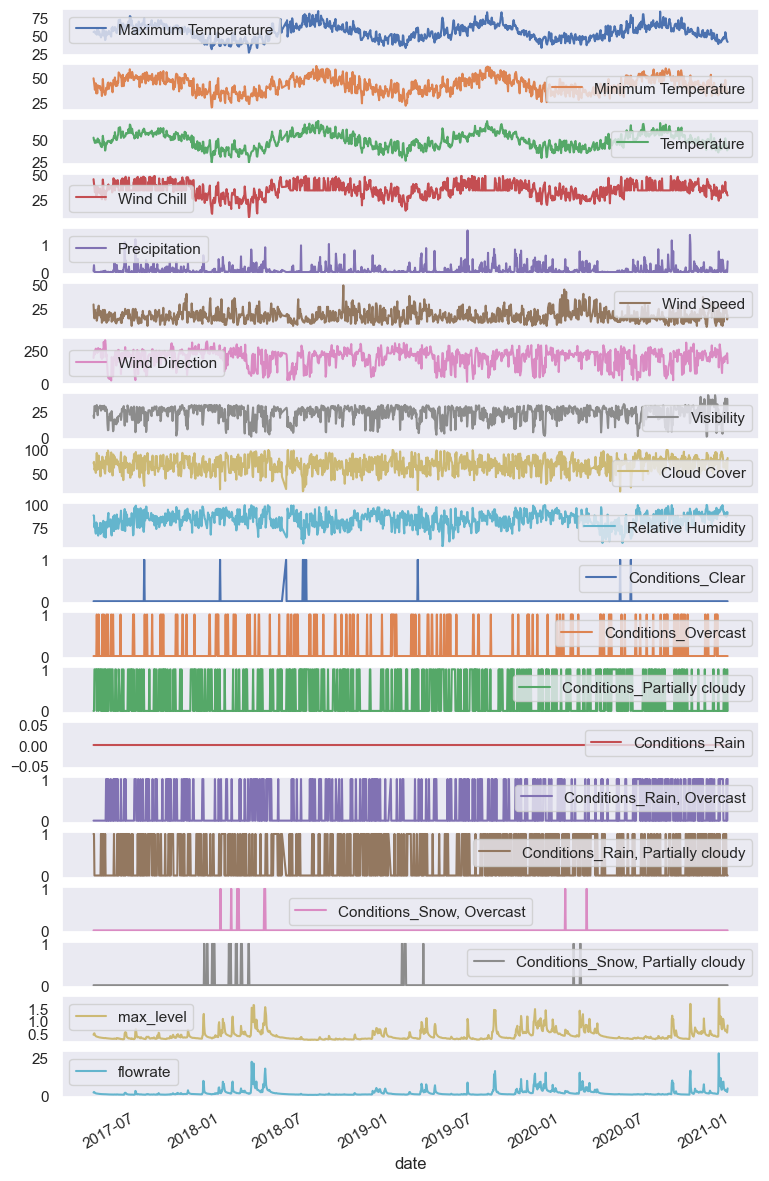

In [53]:
merged_data.plot(subplots=True, figsize=(9,16))

#### Scale the data for model building

Scaling is done to make the model converge faster and generally perform better

In [54]:
df_input = merged_data

In [55]:
# scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [56]:
data_scaled[14]

array([0.41696113, 0.51536643, 0.45814978, 0.69099757, 0.        ,
       0.28026906, 0.73290807, 0.74747475, 0.71888889, 0.56223652,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06219807, 0.02340426])

###### Configure GPU (Automatically skips if GPU is not found)

In [57]:
# This is to configure GPU and avoid OOM error by setting GPU memory consumption growth
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
except Exception as e:
    print("Error configuring GPU: \n", e)

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(gpus)

## Predict future data points

In [58]:
def structure_data(dataset, n_future, n_past):
    """
    This function is used to split the data into features and targets, structuring the training
    data to look like the number of days backward the model should look, and the number of days forward
    the model should predict.
    
    Returns:
        dataX: features
        dataY: targets
    """
    dataX = []
    dataY = []
    
    for i in range(n_past, len(dataset) - n_future +1):
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i + future - 1:i + n_future, -1])
        
    dataX, dataY = np.array(dataX), np.array(dataY)
    
    return dataX, dataY
        

The last column of the data (River Flow Rate) is selected as the target column, this is because the Max Level column is a function of flow rate, as can be observed on te plot of the merged data above

In [59]:
# set future as the number of days forward to predict and past as the number of previous days to
# look back to in order to make predictions
future = 1
past = 7

# define the data structure to follow that pattern
trainX, trainY = structure_data(data_scaled, future, past)

In [60]:
trainX.shape

(1336, 7, 20)

In [61]:
trainY

array([[0.03346556],
       [0.03184277],
       [0.02993148],
       ...,
       [0.08131987],
       [0.06981608],
       [0.15647313]])

##### Model Architecture

In [62]:
model = tf.keras.Sequential()

model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 256)            283648    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 256)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 256)           394240    
 l)                                                              
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 256)            0         
                                                                 
 dropout (Dropout)           (None, 7, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                   

#### Train Model

Uncomment the next two code blocks to train and save a new model, else, proceed with loading a pretrained model

In [63]:
# # set conditions to stop training if the model begins to overfit
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                   patience=2, 
#                                                   mode='min')

# history = model.fit(trainX, trainY, 
#                     epochs= 50, batch_size= 32, 
#                     validation_split=0.1, verbose=1, 
#                     callbacks=[early_stopping])

In [64]:
# # Save model
# joblib.dump(history.history, '../models/model_history.pkl')

# model.save('model.h5')

In [66]:
# Load model
model = load_model('../models/model.h5')

### Forecasting

In [67]:
days = 120
train_dates = combined_data['date']
n_future = len(train_dates[days:])


# Future dates
# forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=days, freq='1d').tolist()

# Past dates
forecast_period_dates = pd.date_range(list(train_dates[days:])[0], periods=n_future, freq='1d').tolist()

In [68]:
# Future forecast
# forecast = model.predict(trainX[-days:])

# Past forecast
forecast = model.predict(trainX[-n_future:])

39/39 [==============================] - 5s 25ms/step


In [69]:
print("Number of days forecast: ",len(forecast), " days")

Number of days forecast:  1223  days


In [70]:
# concatenate the test data and the pedictions into one dataframe
df_pred = pd.concat([pd.DataFrame(data_scaled[:,:-1][days:]), pd.DataFrame(forecast)], axis=1)

In [71]:
y_pred_future = scaler.inverse_transform(df_pred.dropna())[:,-1]

In [72]:
# convert timestamps to date
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [73]:
len(forecast_dates)

1223

In [74]:
len(y_pred_future)

1223

In [75]:
# make forecasts dataframe
df_forecast = pd.DataFrame({'date': np.array(forecast_dates), 'flowrate':y_pred_future})
df_forecast['date'] = pd.to_datetime(df_forecast.date)

In [76]:
original = combined_data[['date', 'flowrate']]
original.date = pd.to_datetime(original.date)

C:\Users\Abraham Audu\AppData\Local\Temp\ipykernel_4152\775145215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original.date = pd.to_datetime(original.date)


### Plot original data and predictions

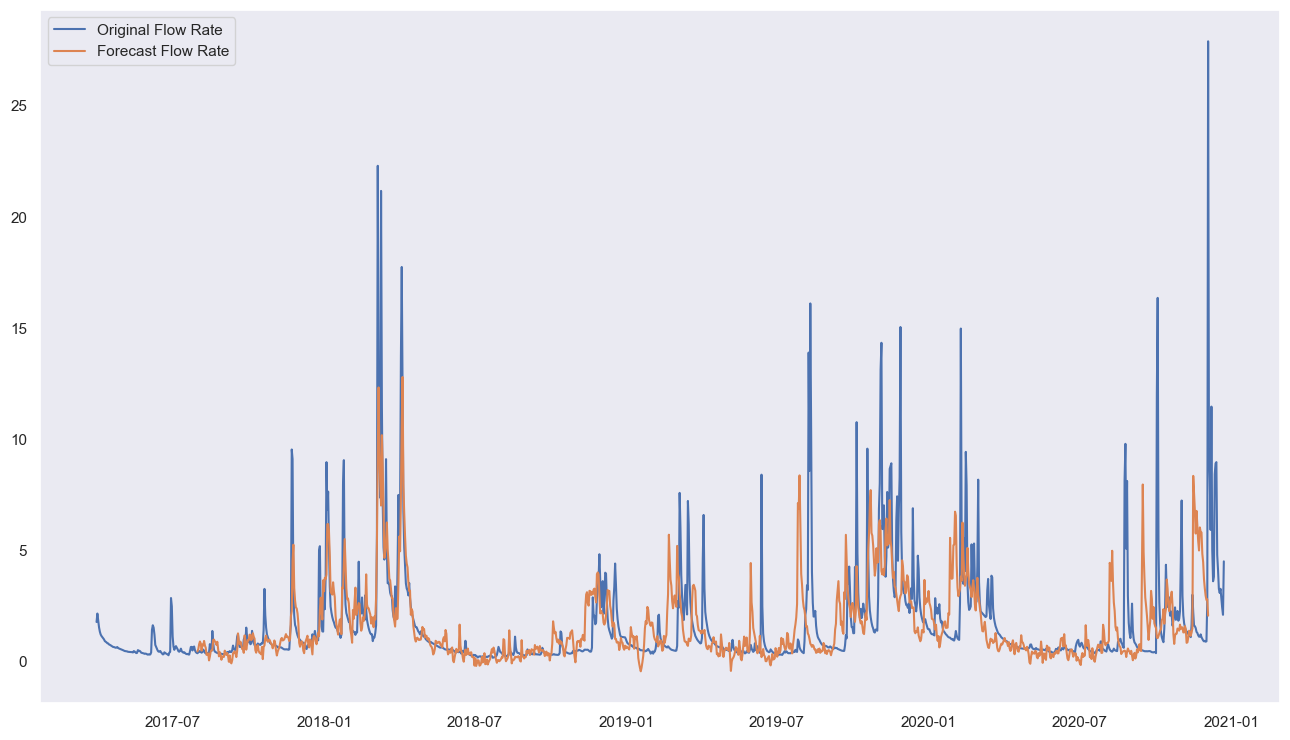

In [77]:
# sns.lineplot(original['date'], original['flowrate'])
# sns.lineplot(df_forecast.date, df_forecast.flowrate)
plt.figure(figsize=(16,9))
plt.plot(original.date, original.flowrate, label='Original Flow Rate')
plt.plot(df_forecast.date, df_forecast.flowrate, label='Forecast Flow Rate')
plt.legend()

Although the model predicts regular data with a lot of noise, it is able to predict impending spikes in the volume flow rate of the river

### Evaluation

In [78]:
def stat_eval(test_df: pd.DataFrame, predictions: pd.DataFrame):
    """
    Carries out statistical evaluation of model based on test data and 
    prediction. 
    
    Prints and returns a summary dictionary
    """
    # statistical evaluations
    
    print("="*5,"Statistical Eval","="*5,"\n")

    rmse = math.sqrt(mean_squared_error(predictions, test_df))

    print(f"Mean val flowrate: {round(mean(test_df), 4)} -- RMSE: {round(rmse, 4)}",
         f"-- RMSE < 10% Mean: ", round(rmse, 4)< round(mean(test_df), 4)/10)
                    
    return rmse

In [79]:
stat_eval(original[days:].flowrate, df_forecast.flowrate)

===== Statistical Eval ===== 

Mean val flowrate: 1.7314 -- RMSE: 1.6348 -- RMSE < 10% Mean:  False


1.634844775086951

In [85]:
min(original[days:].flowrate)

0.17

In [86]:
max(original[days:].flowrate)

27.9